In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [115]:
# Load bitstream, enable external clock
# (don't forget to reload with external clock disabled when you no longer want it)
soc = QickSoc(external_clk=True)
soccfg = soc
print(soccfg)

resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.234
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)


In [196]:
import qick
print(qick.__version__)

0.2.234


### Hardware Configuration

You should cable the board in loopback, connecting one DAC to one ADC. You can set appropriate generator and readout numbers in the cell below, which will be used in `res_ch` and `ro_chs` entries in the program dictionaries below.

For example, for a ZCU111 you might connect DAC229_T1_CH3 to ADC224_T0_CH0 (these are the labels on the XM500 balun board). The DAC and ADC lists tell you that these are DAC tile 1, block 3, and ADC tile 0, block 0. The generator and readout lists tell you that these are driven by generator 6 and readout 0, and your QICK programs will reference those IDs.

In [4]:
GEN_CH = 6
RO_CH = 1

### loopback program
This is a simplified version of the loopback program in the 00 demo, with added parameters to allow for setting different upconversion and downconversion frequencies, changing the NQZ setting of the generator, and changing the generator mode to periodic (CW) for checking power levels with a spectrum analyzer.

In [83]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=GEN_CH, nqz=cfg["nqz"])
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        readoutlen = self.us2cycles(cfg["readout_length"], ro_ch=RO_CH)
        self.declare_readout(ch=RO_CH, length=readoutlen, freq=self.cfg["ro_freq"], gen_ch=GEN_CH)

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=GEN_CH, ro_ch=RO_CH)
        phase = self.deg2reg(cfg["res_phase"], gen_ch=GEN_CH)
        gain = cfg["pulse_gain"]
        pulselen = self.us2cycles(cfg["length"], gen_ch=GEN_CH)
        self.set_pulse_registers(ch=GEN_CH, freq=freq, phase=phase, gain=gain, style="const", length=pulselen,
                                mode=cfg["mode"])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=GEN_CH, 
                     adcs=[RO_CH],
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

  0%|          | 0/100 [00:00<?, ?it/s]

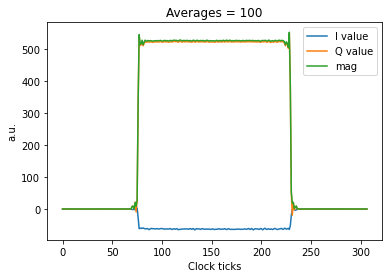

In [104]:
# note the long relax_delay, for a shot time of 0.1 ms
# this will let us check for phase coherence over time with a multi-rep measurement
config={"reps":1, # --Fixed
        "relax_delay":100.0, # --us
        "res_phase":0, # --degrees
        "length":0.5, # [us]
        "readout_length":1.0, # [us]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 5500, # [MHz]
        "ro_freq": 5500, # [MHz]
        "nqz": 2,
        "adc_trig_offset": 0.2, # [us]
        "soft_avgs":100,
        "mode": "oneshot"
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

  0%|          | 0/10000 [00:00<?, ?it/s]

averaged IQ: ([array([-31.51874691])], [array([260.54591466])])


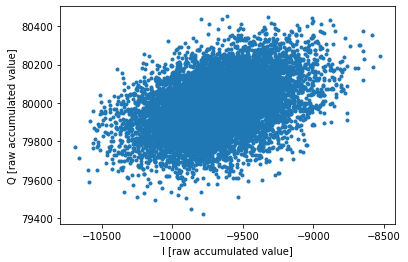

In [105]:
# do a multi-rep measurement and plot the shot-by-shot IQ values, to show stability
# some transient phase drift is expected, particularly at high IF
# the transient should settle down with time, and we've never seen it exceed 100 mr
# but if the phase keeps rotating forever by a constant rate, that indicates a frequency mismatch
config['reps'] = 10000
config['soft_avgs'] = 1

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

In [79]:
# lowest common multiple of the upconversion and downconversion frequency steps, in MHz
# with the standard ZCU216 firmware, this common step is 8 Hz
print(soccfg.calc_fstep(soccfg['readouts'][RO_CH], soccfg['gens'][GEN_CH]))

8.0108642578125e-06


  0%|          | 0/10000 [00:00<?, ?it/s]

averaged IQ: ([array([2.49178893])], [array([2.22558371])])


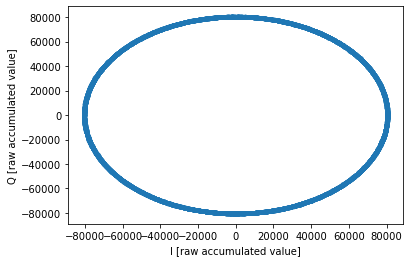

In [106]:
# intentionally mismatch the upconversion and downconversion frequencies by 10 Hz (this'll get rounded to 8 Hz)
# now you'll see the phase rotate through a full circle
# shots (whether using reps or soft_avgs) will not average coherently, the amplitude will shrink
config['reps'] = 10000
config['soft_avgs'] = 1
config['ro_freq'] = config['pulse_freq'] - 10e-6

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

In [123]:
print(245.760*18)
print(245.760*4)
print(245.760*22)

4423.68
983.04
5406.719999999999


  0%|          | 0/1 [00:00<?, ?it/s]

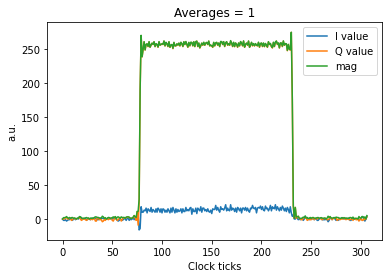

In [136]:
# note the long relax_delay, for a shot time of 0.1 ms
# this will let us check for phase coherence over time with a multi-rep measurement
config={"reps":1, # --Fixed
        "relax_delay":100.0, # --us
        "res_phase":0, # --degrees
        "length":0.5, # [us]
        "readout_length":1.0, # [us]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 5406.72, # [MHz]
        "ro_freq": 983.04, # [MHz]
        "nqz": 2,
        "adc_trig_offset": 0.2, # [us]
        "soft_avgs":1,
        "mode": "oneshot"
#         "mode": "periodic"
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

  0%|          | 0/10000 [00:00<?, ?it/s]

averaged IQ: ([array([-91.9602798])], [array([-40.65938469])])


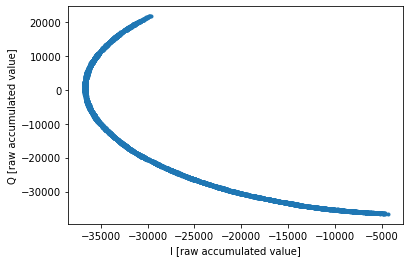

In [134]:
# do a multi-rep measurement and plot the shot-by-shot IQ values, to show stability
# some transient phase drift is expected, particularly at high IF
# the transient should settle down with time, and we've never seen it exceed 100 mr
# but if the phase keeps rotating forever by a constant rate, that indicates a frequency mismatch
config['reps'] = 10000
config['soft_avgs'] = 1

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

  0%|          | 0/10000 [00:00<?, ?it/s]

averaged IQ: ([array([-0.13514039])], [array([5.34224169])])


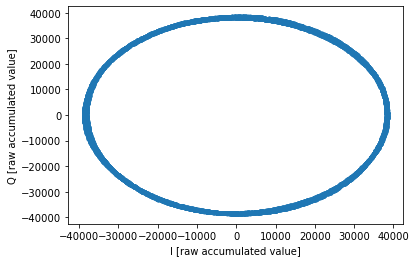

In [155]:
# do a multi-rep measurement and plot the shot-by-shot IQ values, to show stability
# some transient phase drift is expected, particularly at high IF
# the transient should settle down with time, and we've never seen it exceed 100 mr
# but if the phase keeps rotating forever by a constant rate, that indicates a frequency mismatch
config['reps'] = 10000
config['soft_avgs'] = 1
config['relax_delay'] = 1000.0

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=True)
print("averaged IQ:", iq_list)
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')
plt.ylabel("Q [raw accumulated value]")
plt.xlabel("I [raw accumulated value]");

-16.886099707850352


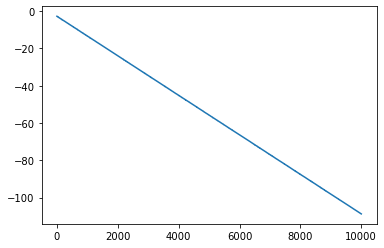

In [152]:
# 4423.68 MHz - 1 Hz
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

-6.868455713753351


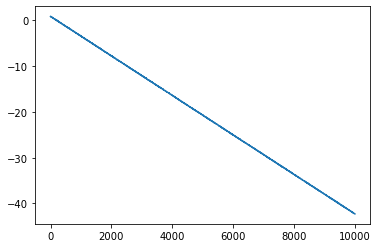

In [154]:
# 4423.68 MHz
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

3.135273761570384


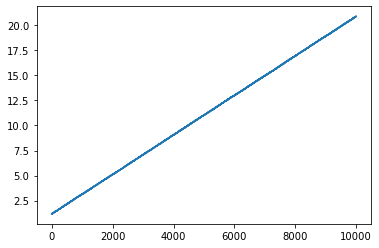

In [156]:
# 4423.68 MHz + 1 Hz
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

  0%|          | 0/10000 [00:00<?, ?it/s]

-6.875319032449852


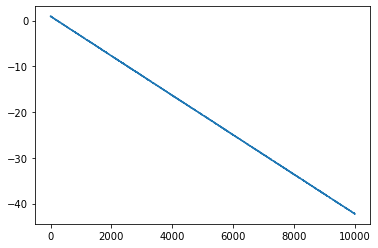

In [162]:
# 4423.68 MHz + 0 Hz
iq_list = prog.acquire(soc, progress=True)
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))

In [159]:
mismatch = np.array([-16.886099707850352,
-6.868455713753351,
3.135273761570384])

In [160]:
mismatch - 10*np.arange(3)

array([-16.88609971, -16.86845571, -16.86472624])

In [120]:
print(soccfg.roundfreq(4500, soccfg['readouts'][RO_CH], soccfg['gens'][GEN_CH]))

4500.000001144409


1708985137.4841647
1708985147.50035
-6.865519130308404


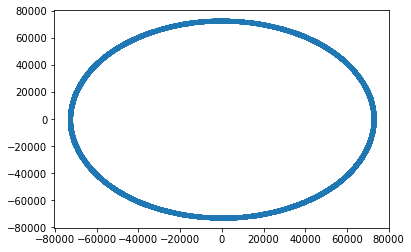

In [191]:
class CWProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=GEN_CH, nqz=cfg["nqz"])
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        readoutlen = self.us2cycles(cfg["readout_length"], ro_ch=RO_CH)
        self.declare_readout(ch=RO_CH, length=readoutlen, freq=self.cfg["ro_freq"], gen_ch=GEN_CH)

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=GEN_CH, ro_ch=RO_CH)
        phase = self.deg2reg(cfg["res_phase"], gen_ch=GEN_CH)
        gain = cfg["pulse_gain"]
        pulselen = self.us2cycles(cfg["length"], gen_ch=GEN_CH)
        self.set_pulse_registers(ch=GEN_CH, freq=freq, phase=phase, gain=gain, style="const", length=pulselen,
                                mode="periodic")

        self.pulse(ch=GEN_CH, t=0)
        
        self.synci(1000)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[RO_CH],
             pins=[0], 
             adc_trig_offset=0)
#         self.pulse(ch=self.cfg["res_ch"])
        self.waiti(0,0)
#         self.synci(self.us2cycles(self.cfg["relax_delay"])//2)
        self.synci(self.us2cycles(self.cfg["relax_delay"]))
#         self.measure(pulse_ch=GEN_CH, 
#                      adcs=[RO_CH],
#                      pins=[0], 
#                      adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
#                      wait=True,
#                      syncdelay=self.us2cycles(self.cfg["relax_delay"]))
#         self.measure(pulse_ch=GEN_CH, 
#                      adcs=[RO_CH],
#                      pins=[0], 
#                      adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
#                      wait=True,
#                      syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        
config={"reps":100000, # --Fixed
        "relax_delay":100.0, # --us
        "res_phase":0, # --degrees
        "length":0.5, # [us]
        "readout_length":1.0, # [us]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 5406.72, # [MHz]
        "ro_freq": 983.04, # [MHz]
        "nqz": 2,
        "adc_trig_offset": 0.2, # [us]
        "soft_avgs":1
       }

prog =CWProgram(soccfg, config)
print(time.time())
iq_list = prog.acquire(soc, progress=False)
print(time.time())
phases = np.unwrap(np.angle(prog.get_raw()[0][:,0].dot([1,1j])))
# plt.plot(phases)
print((phases[-1]-phases[0])/(2*np.pi))
plt.plot(prog.di_buf[0], prog.dq_buf[0], '.')